In [82]:
import string
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion

import joblib
# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from source import my_tokenizer

This is the main preprocessing notebook. I will use TF-IDF to vectorise the words, using a custom tokeniser to remove stop words, small inconsietnecies in the text, as well as understanding what words are not in the english language.

In [83]:
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package wordnet to /Users/edo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/edo/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [86]:
df = pd.read_parquet("../data/clean_FINALREVIEWS.parquet")

Dropping duplicated reviews that arise through dropping metadata columns.

In [87]:
df["reviewText"].duplicated().sum()

81839

In [88]:
df = df.drop_duplicates(ignore_index=True, subset="reviewText")

In [89]:
df.head(10)

,overall,reviewText,asin,length
0,5.0,Looks even better in person. Be careful to not...,7508492919,271
1,5.0,When you don't want to spend a whole lot of ca...,7508492919,102
2,3.0,"so the case came on time, i love the design. I...",7508492919,257
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,7508492919,92
4,4.0,"I liked it because it was cute, but the studs ...",7508492919,150
5,2.0,The product looked exactly like the picture an...,7508492919,159
6,3.0,I FINALLY got my case today. It took forever t...,7508492919,344
7,5.0,It is a very cute case. None of the jewels hav...,7508492919,327
8,1.0,DO NOT BUY! this item is seriously cheap as he...,7508492919,190
9,4.0,I really love this case... you have to keep yo...,7508492919,188


In [90]:
pd.DataFrame(np.unique(df['overall'], return_counts=True)).T.set_index(0)

,1
0,
1.0,69116.0
2.0,48545.0
3.0,78978.0
4.0,134018.0
5.0,473744.0


Adding length of reviews to each review

In [91]:
rev_len = list()
for review in df["reviewText"]:
    rev_len.append(len(str(review)))

In [92]:
df["length"] = rev_len

In [93]:
df["length"].describe()

count    804401.000000
mean        247.048186
std         385.168125
min           1.000000
25%          62.000000
50%         136.000000
75%         282.000000
max       33457.000000
Name: length, dtype: float64

In [94]:
shorter = df[df["length"]<=500].copy()


In [95]:
shorter["reviewText"].fillna("", inplace=True)

In [96]:
shorter = shorter.reset_index(drop='index')

In [97]:
shorter["binary"]= np.where(shorter['overall']>3, 1, 0)

In [98]:
shorter.head(10)

,overall,reviewText,asin,length,binary
0,5.0,Looks even better in person. Be careful to not...,7508492919,271,1
1,5.0,When you don't want to spend a whole lot of ca...,7508492919,102,1
2,3.0,"so the case came on time, i love the design. I...",7508492919,257,0
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,7508492919,92,0
4,4.0,"I liked it because it was cute, but the studs ...",7508492919,150,1
5,2.0,The product looked exactly like the picture an...,7508492919,159,0
6,3.0,I FINALLY got my case today. It took forever t...,7508492919,344,0
7,5.0,It is a very cute case. None of the jewels hav...,7508492919,327,1
8,1.0,DO NOT BUY! this item is seriously cheap as he...,7508492919,190,0
9,4.0,I really love this case... you have to keep yo...,7508492919,188,1


In [99]:
shorter.isna().sum()

overall       0
reviewText    0
asin          0
length        0
binary        0
dtype: int64

In [100]:
shorter.duplicated(subset="reviewText").sum()

0

Vectorising based on just a train split

In [101]:
X_1 = shorter["reviewText"].copy()
y_1= shorter["binary"]

# 
X_rem, X_test, y_rem, y_test = train_test_split(X_1, y_1, test_size=0.2, stratify=y_1,random_state=42)

In [102]:
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.2,stratify=y_rem, random_state=42)

In [103]:
stop_words = stopwords.words('english')

Using a custom tokenizer, we can strip out bits of reviews that do not provide signal, like short bits of text or stop words. I use the nltk stop words. I will probably return and use a custom stop word list, the my_tokenizer can be found in the source file

Fitting the vectoriser on the reviews, for now 500 features, maybe will need to address this. Also using 1 and 2 grams

In [105]:
# 1 grams
tfidf = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=500)
# tfidf.fit(X_train)
# X_train_transformed = tfidf.transform(X_train)
# X_val_transformed = tfidf.transform(X_val)

In [106]:
# 2_grams
tfidf_2grams = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=100, ngram_range=(2,2))
# tfidf_2grams.fit(X_train)
# X_train_transformed_2grams = tfidf_2grams.transform(X_train)
# X_val_transformed_2grams = tfidf_2grams.transform(X_val)

In [107]:
# feature union to combine 1-gram and 2-gram features
combined_features = FeatureUnion([
    ('1gram', tfidf),
    ('2gram', tfidf_2grams)
])

# Example pipeline
pipeline = Pipeline([
    ('vectorizer', combined_features)
])

In [108]:
pipeline.fit(X_train)
X_train_transformed_pipe = pipeline.transform(X_train)
X_val_transformed_pipe = pipeline.transform(X_val)

In [109]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed_pipe.toarray().sum(axis=0)},
    index=pipeline.get_feature_names_out()
).sort_values("counts", ascending=False)

In [110]:
word_counts.index

Index(['1gram__case', '1gram__phone', '1gram__great', '1gram__work',
       '1gram__good', '1gram__love', '1gram__fit', '2gram__work great',
       '2gram__screen protector', '1gram__use',
       ...
       '1gram__room', '1gram__half', '1gram__minut', '1gram__headset',
       '1gram__next', '1gram__happen', '1gram__vent', '1gram__point',
       '1gram__contact', '1gram__micro'],
      dtype='object', length=600)

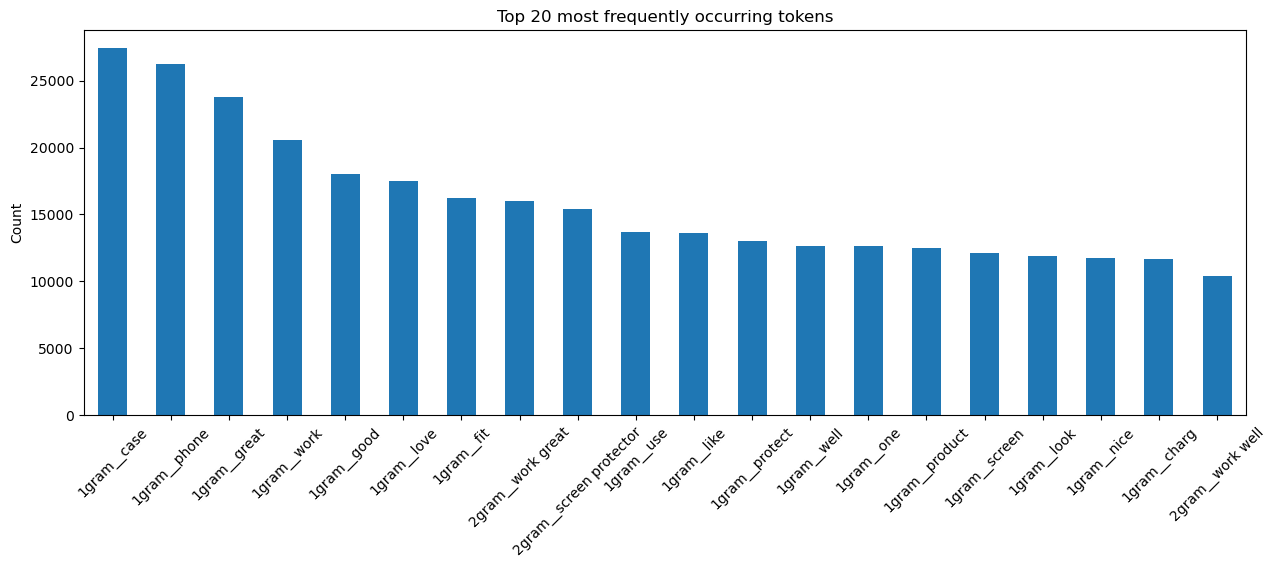

In [111]:
# frequency of 1and2-grams, most reviews are positive  
word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring tokens")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [121]:
# 2-grams vec
review_vectors = pipeline.transform(shorter["reviewText"].fillna(''))


In [123]:
# to a dataframe
review_vectors_df = pd.DataFrame(review_vectors.toarray(), columns=pipeline.get_feature_names_out())


In [124]:
output_df_1_2 = pd.concat([shorter, review_vectors_df], axis=1)


In [126]:
output_df_1_2.to_pickle("../data/reviews_vector_FINAL.pkl")

In [ ]:
# # merge with reviews
# output_df = pd.concat([shorter, review_vectors_df], axis=1)
# # merge with reviews
# output_df_2grams = pd.concat([shorter, review_vectors_df_2grams], axis=1)
# # pickle 1xgrams
# output_df.to_pickle("../data/reviews_vector_1grams.pkl")
# # pickle 2grams
# output_df_2grams.to_pickle("../data/reviews_vector_2grams.pkl")